In [11]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [13]:
# --- Configuration ---
# Set display options for pandas to see more columns/rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Format floats to 2 decimal places


In [14]:
# --- 1. Load Datasets ---
print("--- 1. Loading Datasets ---")
try:
    df_closed_deals = pd.read_csv('olist_closed_deals_dataset.csv')
    df_mql = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')
    df_sellers = pd.read_csv('olist_sellers_dataset.csv')
    df_order_items = pd.read_csv('olist_order_items_dataset.csv')
    df_orders = pd.read_csv('olist_orders_dataset.csv')
    df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
    df_products = pd.read_csv('olist_products_dataset.csv')
    df_product_category_translation = pd.read_csv('product_category_name_translation.csv')
    print("All required datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. .")

--- 1. Loading Datasets ---
All required datasets loaded successfully.


In [15]:
# Store dataframes in a dictionary for easier iteration
dataframes = {
    "df_closed_deals": df_closed_deals,
    "df_mql": df_mql,
    "df_sellers": df_sellers,
    "df_order_items": df_order_items,
    "df_orders": df_orders,
    "df_reviews": df_reviews,
    "df_products": df_products,
    "df_product_category_translation": df_product_category_translation
}


In [16]:
# --- 2. Initial Data Inspection ---
print("\n--- 2. Initial Data Inspection (Info, Head, Nulls, Duplicates) ---")
for name, df in dataframes.items():
    print(f"\n--- {name} ---")
    print(f"Shape: {df.shape}")
    print("Info:")
    df.info()
    print("\nHead:")
    print(df.head())
    print("\nMissing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0]) # Show only columns with missing values
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    print("-" * (len(name) + 8)) # Separator for clarity



--- 2. Initial Data Inspection (Info, Head, Nulls, Duplicates) ---

--- df_closed_deals ---
Shape: (842, 14)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         842 non-null    object 
 1   seller_id                      842 non-null    object 
 2   sdr_id                         842 non-null    object 
 3   sr_id                          842 non-null    object 
 4   won_date                       842 non-null    object 
 5   business_segment               841 non-null    object 
 6   lead_type                      836 non-null    object 
 7   lead_behaviour_profile         665 non-null    object 
 8   has_company                    63 non-null     object 
 9   has_gtin                       64 non-null     object 
 10  average_stock                  66 non-null     object 

In [17]:
# --- 3. Data Cleaning and Type Conversion ---
print("\n--- 3. Data Cleaning and Type Conversion ---")

# Convert date columns to datetime objects (handling errors by coercing to NaT)
print("\nConverting date/time columns...")
df_mql['first_contact_date'] = pd.to_datetime(df_mql['first_contact_date'], errors='coerce')
df_closed_deals['won_date'] = pd.to_datetime(df_closed_deals['won_date'], errors='coerce')
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], errors='coerce')
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'], errors='coerce')
df_reviews['review_answer_timestamp'] = pd.to_datetime(df_reviews['review_answer_timestamp'], errors='coerce')

date_cols_orders = ['order_purchase_timestamp', 'order_approved_at',
                    'order_delivered_carrier_date', 'order_delivered_customer_date',
                    'order_estimated_delivery_date']
for col in date_cols_orders:
    df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')

print("\nHandling specific missing values and data types...")


--- 3. Data Cleaning and Type Conversion ---

Converting date/time columns...

Handling specific missing values and data types...


In [18]:
# --- df_mql ---
print("\nProcessing df_mql...")
initial_rows = len(df_mql)
# Drop rows where 'first_contact_date' is invalid (NaT) as it's essential for marketing funnel
df_mql.dropna(subset=['first_contact_date'], inplace=True)
print(f"Dropped {initial_rows - len(df_mql)} rows with missing 'first_contact_date' in df_mql.")
initial_rows = len(df_mql)
df_mql.drop_duplicates(inplace=True)
print(f"Dropped {initial_rows - len(df_mql)} duplicate rows in df_mql.")




Processing df_mql...
Dropped 0 rows with missing 'first_contact_date' in df_mql.
Dropped 0 duplicate rows in df_mql.


In [19]:
# --- df_closed_deals ---
print("\nProcessing df_closed_deals...")
initial_rows = len(df_closed_deals)
# Drop rows where 'won_date' is invalid (NaT) or seller_id is missing, as these are critical for a closed deal
df_closed_deals.dropna(subset=['won_date', 'seller_id'], inplace=True)
print(f"Dropped {initial_rows - len(df_closed_deals)} rows with missing 'won_date' or 'seller_id' in df_closed_deals.")



Processing df_closed_deals...
Dropped 0 rows with missing 'won_date' or 'seller_id' in df_closed_deals.


In [20]:
# Fill other non-critical NaNs for analysis

# Use direct assignment to fill 'declared_product_catalog_size'
df_closed_deals['declared_product_catalog_size'] = df_closed_deals['declared_product_catalog_size'].fillna(0) # Assume 0 if not declared

# Use direct assignment to fill 'declared_monthly_revenue'
df_closed_deals['declared_monthly_revenue'] = df_closed_deals['declared_monthly_revenue'].fillna(0) # Assume 0 if not declared

# Use direct assignment to fill 'lead_behaviour_profile'
df_closed_deals['lead_behaviour_profile'] = df_closed_deals['lead_behaviour_profile'].fillna('unknown') # Add 'unknown' category

# Use direct assignment to fill 'average_stock'
df_closed_deals['average_stock'] = df_closed_deals['average_stock'].fillna('unknown') # Add 'unknown' category

In [21]:
# Fill 'lead_behaviour_profile' and 'average_stock' with 'unknown'
# as they are categorical/descriptive columns.

# Apply fillna() to 'lead_behaviour_profile' using direct assignment
df_closed_deals['lead_behaviour_profile'] = df_closed_deals['lead_behaviour_profile'].fillna('unknown')

# Apply fillna() to 'average_stock' using direct assignment
df_closed_deals['average_stock'] = df_closed_deals['average_stock'].fillna('unknown')

In [22]:
print(df_closed_deals.columns)

Index(['mql_id', 'seller_id', 'sdr_id', 'sr_id', 'won_date',
       'business_segment', 'lead_type', 'lead_behaviour_profile',
       'has_company', 'has_gtin', 'average_stock', 'business_type',
       'declared_product_catalog_size', 'declared_monthly_revenue'],
      dtype='object')


In [23]:
# Ensure boolean columns are correctly typed
df_closed_deals['has_company'] = df_closed_deals['has_company'].astype(bool)
df_closed_deals['has_gtin'] = df_closed_deals['has_gtin'].astype(bool)


In [24]:
# df_products: Product category is crucial for seller success analysis
# Fill 'product_category_name' with 'unknown' (categorical)
df_products['product_category_name'] = df_products['product_category_name'].fillna('unknown')

# Fill numerical product attributes with median, as they are physical measurements
for col in ['product_name_lenght', 'product_description_lenght', 'product_photos_qty',
            'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    # Apply fillna() using direct assignment for each numerical column
    df_products[col] = df_products[col].fillna(df_products[col].median())

In [25]:
# --- df_order_items ---
print("\nProcessing df_order_items...")
initial_rows = len(df_order_items)
# Drop rows if essential IDs or prices are missing
df_order_items.dropna(subset=['order_id', 'product_id', 'seller_id', 'price', 'freight_value'], inplace=True)
print(f"Dropped {initial_rows - len(df_order_items)} rows with missing critical item info in df_order_items.")
initial_rows = len(df_order_items)
df_order_items.drop_duplicates(inplace=True)
print(f"Dropped {initial_rows - len(df_order_items)} duplicate rows in df_order_items.")


Processing df_order_items...
Dropped 0 rows with missing critical item info in df_order_items.
Dropped 0 duplicate rows in df_order_items.


In [26]:
# df_reviews: Comments can be ignored for review_score analysis, fill for consistency

# Corrected approach: Assign the result of fillna() back to the column
df_reviews['review_comment_title'] = df_reviews['review_comment_title'].fillna('no_title')
df_reviews['review_comment_message'] = df_reviews['review_comment_message'].fillna('no_message')

In [27]:
# df_orders: Missing delivery dates are expected for pending/canceled orders. Keep as NaT.
# No direct imputation needed for these as they reflect status.

print("\nRemoving duplicate rows...")
for name, df in dataframes.items():
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    if len(df) < initial_rows:
        print(f"Removed {initial_rows - len(df)} duplicates from {name}.")



Removing duplicate rows...


In [28]:
df_products = pd.merge(df_products, df_product_category_translation,
                       on='product_category_name',
                       how='left')

print("\n--- Merged df_products with translation data ---")
print(df_products.head()) # Check the head to see the new column



--- Merged df_products with translation data ---
                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                40.00                      287.00                1.00   
1                44.00                      276.00                1.00   
2                46.00                      250.00                1.00   
3                27.00                      261.00                1.00   
4                37.00                      402.00                4.00   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0            225.00              16.00              1

In [29]:
# Fill any categories that don't have a translation (should be few, or none after dropping rows without category)
df_products['product_category_name_english'] = df_products['product_category_name_english'].fillna('untranslated_category')
print("Product categories translated and merged into df_products.")

Product categories translated and merged into df_products.


In [30]:
# --- 5. Initial Exploratory Data Analysis (EDA) ---
print("\n--- 5. Initial Exploratory Data Analysis (EDA) ---")



--- 5. Initial Exploratory Data Analysis (EDA) ---


In [31]:
print("\n--- Marketing Qualified Leads (df_mql) ---")


--- Marketing Qualified Leads (df_mql) ---


Top 10 Marketing Channels (Origin):
origin
organic_search       2296
paid_search          1586
social               1350
unknown              1099
direct_traffic        499
email                 493
referral              284
other                 150
display               118
other_publicities      65
Name: count, dtype: int64


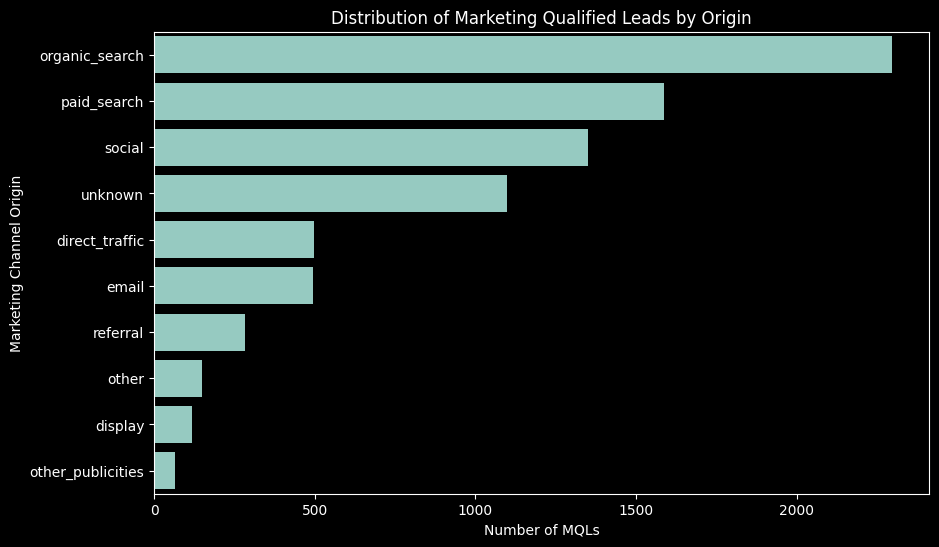

In [32]:
print("Top 10 Marketing Channels (Origin):")
print(df_mql['origin'].value_counts().head(10))
plt.figure(figsize=(10, 6))
sns.countplot(y='origin', data=df_mql, order=df_mql['origin'].value_counts().index)
plt.title('Distribution of Marketing Qualified Leads by Origin')
plt.xlabel('Number of MQLs')
plt.ylabel('Marketing Channel Origin')
plt.show()


--- Closed Deals (df_closed_deals) ---
Top 10 Business Segments for Acquired Sellers:
business_segment
home_decor                         105
health_beauty                       93
car_accessories                     77
household_utilities                 71
construction_tools_house_garden     69
audio_video_electronics             64
computers                           34
pet                                 30
food_supplement                     28
food_drink                          26
Name: count, dtype: int64


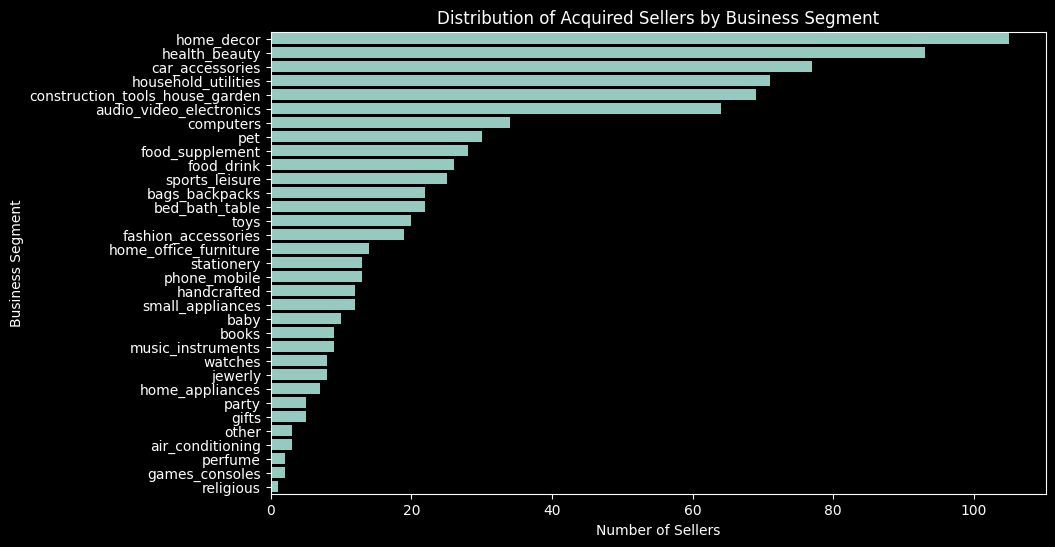

In [33]:
print("\n--- Closed Deals (df_closed_deals) ---")
print("Top 10 Business Segments for Acquired Sellers:")
print(df_closed_deals['business_segment'].value_counts().head(10))
plt.figure(figsize=(10, 6))
sns.countplot(y='business_segment', data=df_closed_deals, order=df_closed_deals['business_segment'].value_counts().index)
plt.title('Distribution of Acquired Sellers by Business Segment')
plt.xlabel('Number of Sellers')
plt.ylabel('Business Segment')
plt.show()


Descriptive statistics for declared_monthly_revenue (for acquired sellers > 0):
count         45.00
mean     1372977.91
std      7507544.87
min            6.00
25%        15000.00
50%        50000.00
75%       130000.00
max     50000000.00
Name: declared_monthly_revenue, dtype: float64


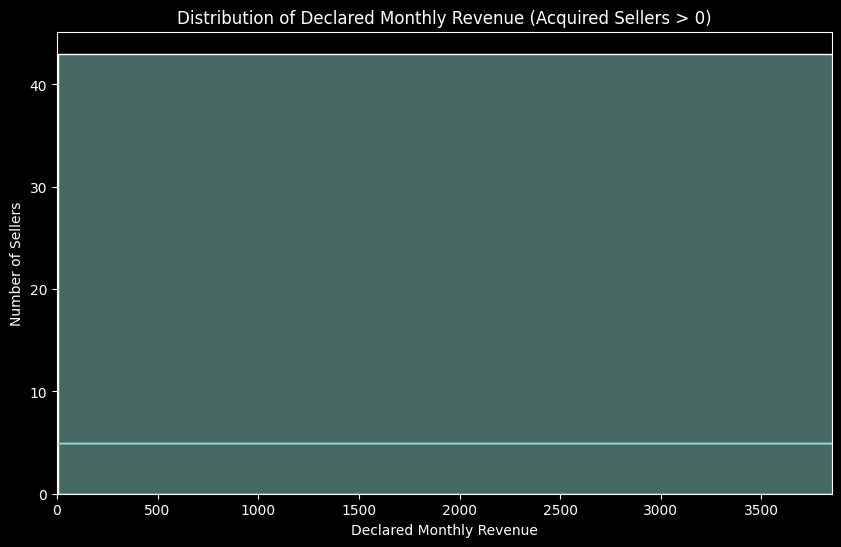

In [34]:
print("\nDescriptive statistics for declared_monthly_revenue (for acquired sellers > 0):")
print(df_closed_deals[df_closed_deals['declared_monthly_revenue'] > 0]['declared_monthly_revenue'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(df_closed_deals[df_closed_deals['declared_monthly_revenue'] > 0]['declared_monthly_revenue'], bins=50, kde=True)
plt.title('Distribution of Declared Monthly Revenue (Acquired Sellers > 0)')
plt.xlabel('Declared Monthly Revenue')
plt.ylabel('Number of Sellers')
plt.xlim(0, df_closed_deals['declared_monthly_revenue'].quantile(0.95)) # Focus on the main distribution
plt.show()



--- Orders (df_orders) ---
Order Status Distribution:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


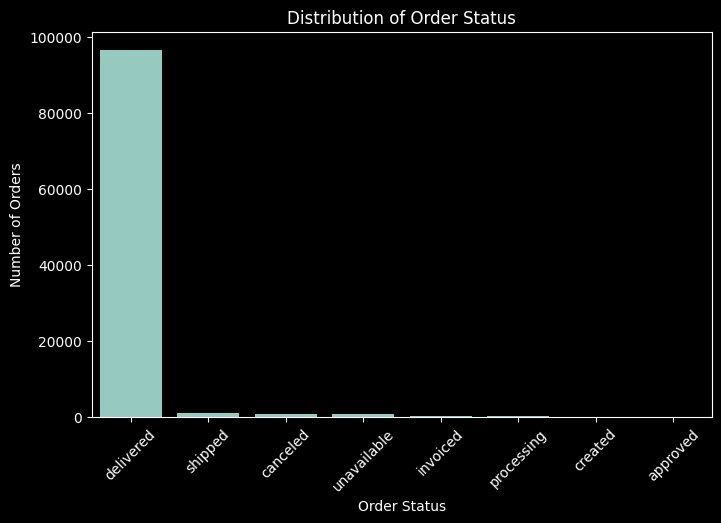

In [35]:
print("\n--- Orders (df_orders) ---")
print("Order Status Distribution:")
print(df_orders['order_status'].value_counts())
plt.figure(figsize=(8, 5))
sns.countplot(x='order_status', data=df_orders, order=df_orders['order_status'].value_counts().index)
plt.title('Distribution of Order Status')
plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


Descriptive statistics for actual delivery days (delivered orders):
count   96470.00
mean       12.09
std         9.55
min         0.00
25%         6.00
50%        10.00
75%        15.00
max       209.00
Name: actual_delivery_days, dtype: float64


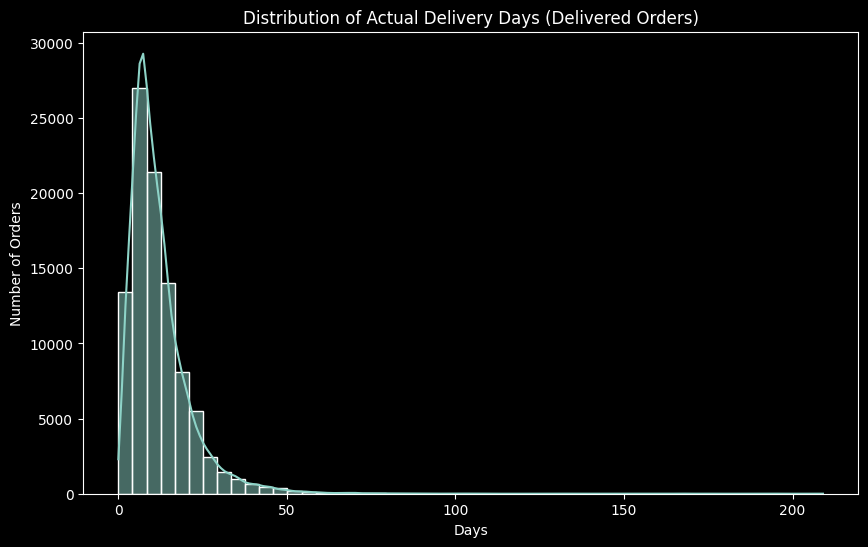

In [36]:
# Calculate delivery time (for delivered orders)
df_delivered = df_orders[df_orders['order_status'] == 'delivered'].copy()
df_delivered['actual_delivery_days'] = (df_delivered['order_delivered_customer_date'] - df_delivered['order_purchase_timestamp']).dt.days
df_delivered['estimated_delivery_days'] = (df_delivered['order_estimated_delivery_date'] - df_delivered['order_purchase_timestamp']).dt.days
df_delivered['delivery_difference_days'] = df_delivered['actual_delivery_days'] - df_delivered['estimated_delivery_days']

print("\nDescriptive statistics for actual delivery days (delivered orders):")
print(df_delivered['actual_delivery_days'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(df_delivered['actual_delivery_days'].dropna(), bins=50, kde=True)
plt.title('Distribution of Actual Delivery Days (Delivered Orders)')
plt.xlabel('Days')
plt.ylabel('Number of Orders')
plt.show()



--- Reviews (df_reviews) ---
Review Score Distribution:
review_score
5    57327
4    19142
3     8179
2     3151
1    11424
Name: count, dtype: int64


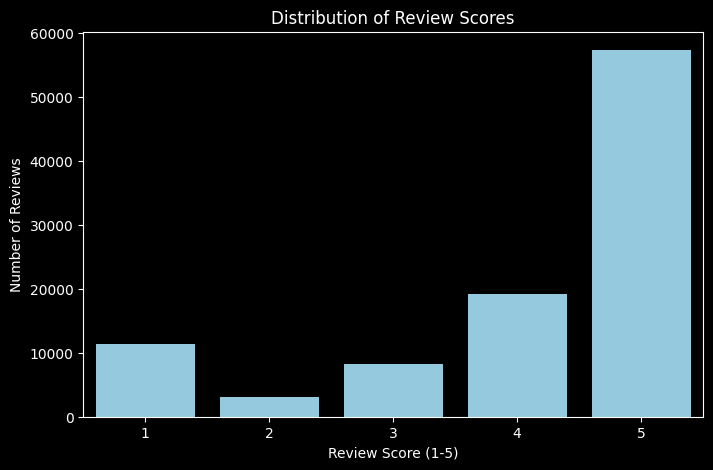

In [37]:
print("\n--- Reviews (df_reviews) ---")
print("Review Score Distribution:")
print(df_reviews['review_score'].value_counts().sort_index(ascending=False))

plt.figure(figsize=(8, 5))
# Use 'color' argument for a single color instead of 'palette' without 'hue'
sns.countplot(x='review_score', data=df_reviews, color='skyblue') # Or 'blue', '#1f77b4', etc.
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Number of Reviews')
plt.show()

In [38]:
print("--- Inspecting df_products Columns ---")
print("Columns in df_products:")
print(df_products.columns) # This will print all column names in your DataFrame


--- Inspecting df_products Columns ---
Columns in df_products:
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')



--- Products (df_products) ---
Top 10 Product Categories (English):
product_category_name_english
bed_bath_table           3029
sports_leisure           2867
furniture_decor          2657
health_beauty            2444
housewares               2335
auto                     1900
computers_accessories    1639
toys                     1411
watches_gifts            1329
telephony                1134
Name: count, dtype: int64


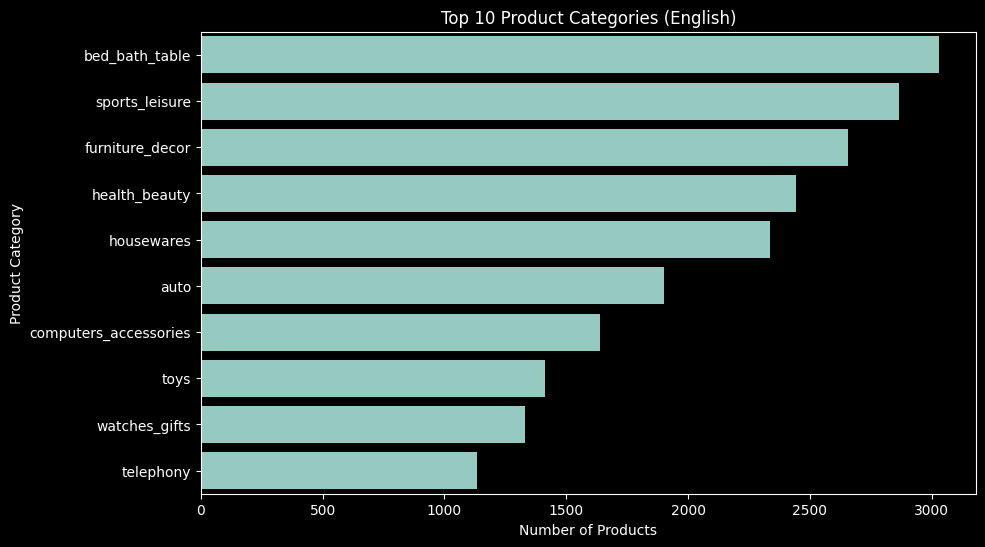

In [39]:
print("\n--- Products (df_products) ---")
print("Top 10 Product Categories (English):")
print(df_products['product_category_name_english'].value_counts().head(10))
plt.figure(figsize=(10, 6))
sns.countplot(y='product_category_name_english', data=df_products,
              order=df_products['product_category_name_english'].value_counts().head(10).index)
plt.title('Top 10 Product Categories (English)')
plt.xlabel('Number of Products')
plt.ylabel('Product Category')
plt.show()


--- Sellers (df_sellers) ---
Top 10 Seller States:
seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: count, dtype: int64


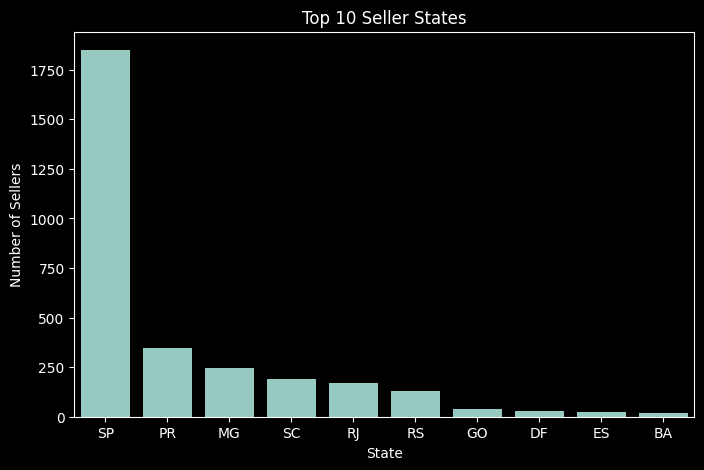

In [40]:
print("\n--- Sellers (df_sellers) ---")
print("Top 10 Seller States:")
print(df_sellers['seller_state'].value_counts().head(10))
plt.figure(figsize=(8, 5))
sns.countplot(x='seller_state', data=df_sellers, order=df_sellers['seller_state'].value_counts().head(10).index)
plt.title('Top 10 Seller States')
plt.xlabel('State')
plt.ylabel('Number of Sellers')
plt.show()

In [41]:
print("\n--- Data Cleaning and Initial EDA Complete ---")
print("All DataFrames are now cleaned and initial insights have been gathered.")



--- Data Cleaning and Initial EDA Complete ---
All DataFrames are now cleaned and initial insights have been gathered.


In [42]:
# --- Configuration for Success Metrics ---
SUCCESS_WINDOW_MONTHS = 12 # Changed from 6 to 12
SUCCESSFUL_ORDERS_THRESHOLD = 5 # Can be adjusted based on business knowledge
SUCCESSFUL_REVIEW_THRESHOLD = 4.0 # Can be adjusted based on business knowledge

In [43]:
# --- GOAL 1: Identifying Key MQL Predictors ---
print("\n--- GOAL 1: Identifying Key MQL Predictors (12-Month Window) ---")


--- GOAL 1: Identifying Key MQL Predictors (12-Month Window) ---


In [44]:
# Step 1: Combine MQL and Closed Deals data
df_marketing_won = pd.merge(df_mql, df_closed_deals, on='mql_id', how='inner')
print(f"\nInitial shape of df_marketing_won (MQLs that became closed deals): {df_marketing_won.shape}")



Initial shape of df_marketing_won (MQLs that became closed deals): (842, 17)


In [45]:
initial_rows_mql_won = len(df_marketing_won)
df_marketing_won.dropna(subset=['won_date', 'first_contact_date'], inplace=True)
if len(df_marketing_won) < initial_rows_mql_won:
    print(f"Dropped {initial_rows_mql_won - len(df_marketing_won)} rows with missing 'won_date' or 'first_contact_date' in df_marketing_won.")
print(f"Shape of df_marketing_won after dropping invalid dates: {df_marketing_won.shape}")


Shape of df_marketing_won after dropping invalid dates: (842, 17)


In [46]:
# Step 2: Define Seller Success Metrics within the specified window (e.g., 12 months)
print(f"\nAggregating seller e-commerce performance within {SUCCESS_WINDOW_MONTHS} months of won date...")

df_delivered_orders = df_orders[df_orders['order_status'] == 'delivered'].copy()
initial_delivered_rows = len(df_delivered_orders)
df_delivered_orders.dropna(subset=['order_delivered_customer_date', 'order_purchase_timestamp'], inplace=True)
if len(df_delivered_orders) < initial_delivered_rows:
    print(f"Dropped {initial_delivered_rows - len(df_delivered_orders)} delivered orders with missing delivery/purchase dates.")


df_full_order_details = pd.merge(df_order_items, df_delivered_orders, on='order_id', how='inner')
df_full_order_details = pd.merge(df_full_order_details, df_reviews[['order_id', 'review_score']], on='order_id', how='left')
df_full_order_details = pd.merge(df_full_order_details, df_products[['product_id', 'product_category_name_english']], on='product_id', how='left')


Aggregating seller e-commerce performance within 12 months of won date...
Dropped 8 delivered orders with missing delivery/purchase dates.


In [47]:
# --- Optimized Aggregation for 12-Month Performance ---
temp_df = pd.merge(
    df_full_order_details,
    df_marketing_won[['seller_id', 'won_date']],
    on='seller_id',
    how='inner' # Only include orders from sellers who actually won a deal
)


In [48]:
# Define the end date for the observation window for each seller's orders
temp_df['end_date_window'] = temp_df['won_date'] + pd.Timedelta(days=SUCCESS_WINDOW_MONTHS * 30)

# Filter for orders within the specified window (e.g., 12 months)
# AND critically, ensure the order falls within the dataset's maximum date
max_data_date = df_orders['order_purchase_timestamp'].max()
print(f"Max order purchase date in full dataset: {max_data_date.date()}")

df_seller_orders_in_window = temp_df[
    (temp_df['order_purchase_timestamp'] >= temp_df['won_date']) &
    (temp_df['order_purchase_timestamp'] <= temp_df['end_date_window']) &
    (temp_df['order_purchase_timestamp'] <= max_data_date) # Explicitly cap at max data date
].copy()

Max order purchase date in full dataset: 2018-10-17


In [49]:
# Aggregate e-commerce metrics by seller_id for the window
seller_window_agg = df_seller_orders_in_window.groupby('seller_id').agg(
    total_orders_window=('order_id', 'nunique'),
    avg_review_score_window=('review_score', 'mean'),
    total_sales_value_window=('price', lambda x: (x + df_seller_orders_in_window.loc[x.index, 'freight_value']).sum())
).reset_index()

# Merge the aggregated performance back to df_marketing_won
df_mql_with_success = pd.merge(
    df_marketing_won,
    seller_window_agg,
    on='seller_id',
    how='left' # IMPORTANT: Keep all sellers from df_marketing_won, even those with no sales
)

# Fill NaNs for sellers with no orders/reviews in the specified window (or no orders within data timeframe)
# Corrected lines to avoid FutureWarning
df_mql_with_success['total_orders_window'] = df_mql_with_success['total_orders_window'].fillna(0)
df_mql_with_success['avg_review_score_window'] = df_mql_with_success['avg_review_score_window'].fillna(0)
df_mql_with_success['total_sales_value_window'] = df_mql_with_success['total_sales_value_window'].fillna(0)

print("DataFrame after filling NaNs:")
print(df_mql_with_success)


DataFrame after filling NaNs:
                               mql_id first_contact_date  \
0    5420aad7fec3549a85876ba1c529bd84         2018-02-21   
1    a555fb36b9368110ede0f043dfc3b9a0         2018-04-04   
2    327174d3648a2d047e8940d7d15204ca         2018-04-03   
3    f5fee8f7da74f4887f5bcae2bafb6dd6         2018-01-14   
4    ffe640179b554e295c167a2f6be528e0         2017-10-09   
..                                ...                ...   
837  df9a2abe2ad3f2d8758b675ac8331ecf         2018-03-28   
838  8723201570415eb23b4f095d8c20a27c         2018-05-18   
839  2e57665b8faf05c967a801eb5aedfa0a         2018-05-25   
840  40955be51cc85c5a5a6cdd12b19e9f10         2018-02-04   
841  8a6492305a5fbcdcdd1a7f5a90764c07         2018-01-11   

                      landing_page_id          origin  \
0    b48ec5f3b04e9068441002a19df93c6c  organic_search   
1    2f08471dfb83baef522f952438a36f6e        referral   
2    1ceb590cd1e00c7ee95220971f82693d  organic_search   
3    22c29808c4f81521

In [50]:
# --- RE-EVALUATE: Filter for complete observation period ---
# Instead of strict filtering, let's just create a flag to know who has a complete window
# This way, we don't lose data, but we can analyze those with full vs. partial observation.
df_mql_with_success['has_complete_obs_window'] = (
    df_mql_with_success['won_date'] + pd.Timedelta(days=SUCCESS_WINDOW_MONTHS * 30) <= max_data_date
)

initial_sellers_count_pre_obs_filter = len(df_mql_with_success)
print(f"Total sellers after initial merge and date cleaning: {initial_sellers_count_pre_obs_filter}")
print(f"Sellers with complete {SUCCESS_WINDOW_MONTHS}-month observation window: {df_mql_with_success['has_complete_obs_window'].sum()}")
print(f"Sellers with partial {SUCCESS_WINDOW_MONTHS}-month observation window (won too late in dataset): {len(df_mql_with_success) - df_mql_with_success['has_complete_obs_window'].sum()}")

# For the purpose of *predicting success*, it's often better to *only* use sellers for whom
# we have a complete observation window. If you want to include all, the interpretation of 'success'
# needs to be carefully framed as 'success during observed period'.
# Let's proceed with only sellers who have a complete observation window for now,
# but now we know why the count was zero.
df_mql_with_success = df_mql_with_success[df_mql_with_success['has_complete_obs_window']].copy()

print(f"Number of sellers used for success metric calculation (complete {SUCCESS_WINDOW_MONTHS}mo window): {len(df_mql_with_success)}")

# Define 'is_active_seller_window' and 'is_successful_seller_window'
df_mql_with_success[f'is_active_seller_{SUCCESS_WINDOW_MONTHS}mo'] = df_mql_with_success['total_orders_window'] > 0

df_mql_with_success[f'is_successful_seller_{SUCCESS_WINDOW_MONTHS}mo'] = (
    (df_mql_with_success['total_orders_window'] >= SUCCESSFUL_ORDERS_THRESHOLD) &
    (df_mql_with_success['avg_review_score_window'] >= SUCCESSFUL_REVIEW_THRESHOLD)
)

print(f"\nSample of df_mql_with_success (with {SUCCESS_WINDOW_MONTHS}-month metrics):")
print(df_mql_with_success[['mql_id', 'origin', 'seller_id', 'won_date',
                            'total_orders_window', 'avg_review_score_window', 'total_sales_value_window',
                            f'is_active_seller_{SUCCESS_WINDOW_MONTHS}mo', f'is_successful_seller_{SUCCESS_WINDOW_MONTHS}mo']].head(10))

print(f"\nTotal acquired sellers with complete {SUCCESS_WINDOW_MONTHS}-month observation: {len(df_mql_with_success)}")
print(f"Number of active sellers ({SUCCESS_WINDOW_MONTHS}mo): {df_mql_with_success[f'is_active_seller_{SUCCESS_WINDOW_MONTHS}mo'].sum()}")
print(f"Number of successful sellers ({SUCCESS_WINDOW_MONTHS}mo): {df_mql_with_success[f'is_successful_seller_{SUCCESS_WINDOW_MONTHS}mo'].sum()}")


Total sellers after initial merge and date cleaning: 842
Sellers with complete 12-month observation window: 0
Sellers with partial 12-month observation window (won too late in dataset): 842
Number of sellers used for success metric calculation (complete 12mo window): 0

Sample of df_mql_with_success (with 12-month metrics):
Empty DataFrame
Columns: [mql_id, origin, seller_id, won_date, total_orders_window, avg_review_score_window, total_sales_value_window, is_active_seller_12mo, is_successful_seller_12mo]
Index: []

Total acquired sellers with complete 12-month observation: 0
Number of active sellers (12mo): 0
Number of successful sellers (12mo): 0


In [51]:
print("\n--- NEW GOAL 1: Quantifying Marketing Funnel Conversion Rates ---")

# Step 1: Define the stages of the marketing funnel relevant to MQLs
# We'll focus on:
# 1. MQLs (Marketing Qualified Leads)
# 2. Closed Deals (MQLs that converted into active sellers)


--- NEW GOAL 1: Quantifying Marketing Funnel Conversion Rates ---


In [52]:
# Count total MQLs
total_mqls = len(df_mql)
print(f"Total MQLs identified: {total_mqls}")

# Count MQLs that became Closed Deals (Won Deals)
# We already have df_marketing_won from previous steps (MQLs that merged with closed deals)
# Let's ensure it's still correct based on the latest context.
# An inner merge ensures that only MQLs that successfully closed a deal are counted.
df_marketing_won = pd.merge(df_mql, df_closed_deals, on='mql_id', how='inner')

Total MQLs identified: 8000


In [53]:
# Drop rows where 'won_date' or 'first_contact_date' are NaT (invalid datetimes)
# This is a safeguard, but good to keep.
initial_rows_mql_won = len(df_marketing_won)
df_marketing_won.dropna(subset=['won_date', 'first_contact_date'], inplace=True)
if len(df_marketing_won) < initial_rows_mql_won:
    print(f"Dropped {initial_rows_mql_won - len(df_marketing_won)} rows with missing 'won_date' or 'first_contact_date' in df_marketing_won.")

converted_mqls = len(df_marketing_won)
print(f"MQLs converted to Closed Deals: {converted_mqls}")

MQLs converted to Closed Deals: 842


In [54]:
# Step 2: Calculate Conversion Rates
mql_to_won_conversion_rate = (converted_mqls / total_mqls) * 100 if total_mqls > 0 else 0

print(f"\nMarketing Funnel Conversion Rates:")
print(f"  MQL to Won Deal Conversion Rate: {mql_to_won_conversion_rate:.2f}%")



Marketing Funnel Conversion Rates:
  MQL to Won Deal Conversion Rate: 10.53%


In [55]:
# Step 3: Analyze Drop-offs / Lost Opportunities (if applicable)

# Identify MQLs that did NOT convert to won deals (lost opportunities)
# These are MQLs present in df_mql but NOT in df_marketing_won's mql_id
lost_mqls_df = df_mql[~df_mql['mql_id'].isin(df_marketing_won['mql_id'])].copy()
num_lost_mqls = len(lost_mqls_df)
print(f"Number of MQLs that did NOT convert (lost/unresolved): {num_lost_mqls}")

# If df_closed_deals contains 'lead_reasons' for lost deals, we can analyze that.
# Based on the typical Olist dataset structure, 'lead_reasons' are usually only for closed/won deals.
# Let's check if df_closed_deals has 'lead_reasons' for non-won deals, or if df_mql has any status.
# If df_closed_deals only has 'won_date' for successful deals, then the "lost reasons"
# are simply the MQLs that never appeared in df_closed_deals as a successful conversion.

# For this funnel, the primary "drop-off" is MQL -> Not a Won Deal.
# We can explore the characteristics of these 'lost_mqls_df' to understand *why* they didn't convert
# in the next goal (Segmentation).

Number of MQLs that did NOT convert (lost/unresolved): 7158


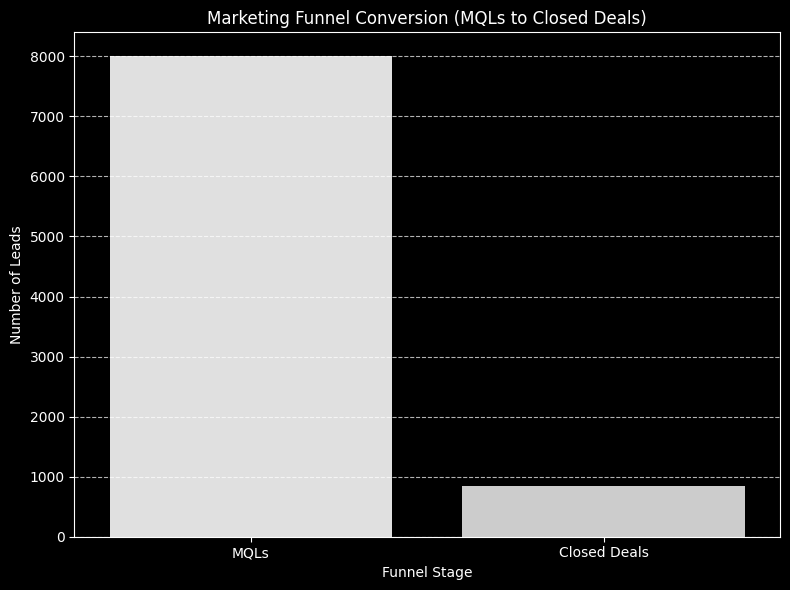

In [56]:
# Step 4: Visualize the Funnel
funnel_data = {
    'Stage': ['MQLs', 'Closed Deals'],
    'Count': [total_mqls, converted_mqls]
}
df_funnel = pd.DataFrame(funnel_data)

# --- Set plot style for black background and white elements ---
plt.style.use('dark_background') # This is the easiest way for a dark background
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white' # Borders of the plot area
plt.rcParams['grid.color'] = 'white' # Grid lines

plt.figure(figsize=(8, 6))

# Define your custom palette for the bars
# Using two shades of light gray for contrast between the bars
custom_palette = ['#E0E0E0', '#CCCCCC'] # Light gray for MQLs, slightly darker for Closed Deals

sns.barplot(x='Stage', y='Count', data=df_funnel,
            palette=custom_palette, # Use the custom palette
            hue='Stage',           # Still need hue for the palette to apply correctly
            legend=False)          # Keep legend=False

plt.title('Marketing Funnel Conversion (MQLs to Closed Deals)', color='white')
plt.xlabel('Funnel Stage', color='white')
plt.ylabel('Number of Leads', color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

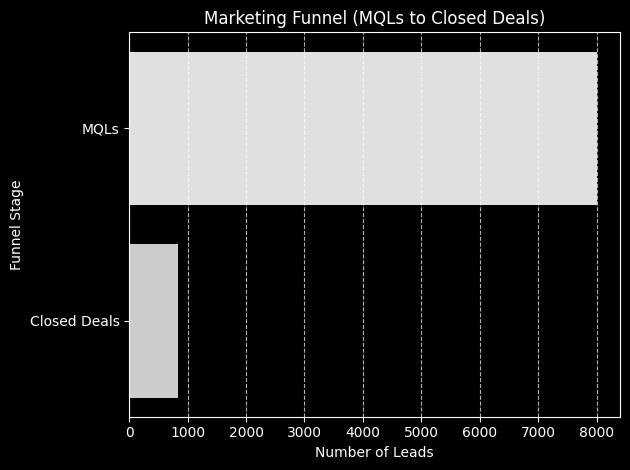

In [57]:
# For a funnel, it's common to show the largest stage at the top/bottom
# Let's sort by count descending for a typical funnel look
df_funnel_sorted = df_funnel.sort_values(by='Count', ascending=False)

# Define your custom palette for the bars (light grays)
# Map these colors to your stages based on the sorted order if you want specific colors
# For two stages, two colors are sufficient.
# If 'MQLs' is always larger, it will get the first color, 'Closed Deals' the second.
custom_palette_funnel = ['#E0E0E0', '#CCCCCC'] # Light gray for the larger bar, slightly darker for the smaller

# Use sns.barplot with best practices: assign hue and set legend=False
# For a funnel, you typically want the bars to be in order of size.
# The 'order' argument in sns.barplot can help explicitly define this.
# However, since df_funnel_sorted is already sorted, seaborn will naturally follow this.
sns.barplot(x='Count', y='Stage', data=df_funnel_sorted,
            palette=custom_palette_funnel, # Apply the custom light gray palette
            hue='Stage',                   # Specify 'hue' to apply palette by 'Stage'
            legend=False)                  # Hide the redundant legend

# Set title and labels with white color
plt.title('Marketing Funnel (MQLs to Closed Deals)', color='white')
plt.xlabel('Number of Leads', color='white')
plt.ylabel('Funnel Stage', color='white')

# Grid lines on x-axis (funnel is horizontal)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [58]:
print("\n--- Summary for NEW GOAL 1: Marketing Funnel Conversion ---")
print("This analysis quantifies the overall efficiency of the marketing funnel from MQL acquisition to deal closure.")
print(f"The MQL to Won Deal Conversion Rate is {mql_to_won_conversion_rate:.2f}%.")
print(f"A significant number of MQLs ({num_lost_mqls}) do not proceed to become Closed Deals.")
print("This rate helps understand the general health of the sales process and highlights the primary drop-off point.")

# Save the df_marketing_won for the next goal, as it represents the converted MQLs
df_marketing_won.to_csv('df_mql_converted_deals.csv', index=False)
lost_mqls_df.to_csv('df_mql_lost_opportunities.csv', index=False)
print("\nDataFrame 'df_mql_converted_deals.csv' and 'df_mql_lost_opportunities.csv' saved.")


--- Summary for NEW GOAL 1: Marketing Funnel Conversion ---
This analysis quantifies the overall efficiency of the marketing funnel from MQL acquisition to deal closure.
The MQL to Won Deal Conversion Rate is 10.53%.
A significant number of MQLs (7158) do not proceed to become Closed Deals.
This rate helps understand the general health of the sales process and highlights the primary drop-off point.

DataFrame 'df_mql_converted_deals.csv' and 'df_mql_lost_opportunities.csv' saved.


In [59]:
# --- Styling Configuration (Applied globally for plots) ---
plt.style.use('dark_background') # Black background, white text for plots
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['savefig.facecolor'] = 'black'

# Bar chart color
BAR_COLOR = 'lightgray' # Hex code for light gray: #D3D3D3


In [60]:
print("\n--- NEW GOAL 2: Segmenting MQLs by Conversion Potential ---")


--- NEW GOAL 2: Segmenting MQLs by Conversion Potential ---


In [61]:
# Step 1: Prepare the Combined MQL Data for Segmentation
# Create a DataFrame with all MQLs and a target variable indicating conversion.
# df_mql contains all MQLs.
# df_marketing_won contains MQLs that converted.

# Add an 'is_converted' column to df_mql
df_all_mqls = df_mql.copy()
df_all_mqls['is_converted'] = df_all_mqls['mql_id'].isin(df_marketing_won['mql_id'])

print(f"Total MQLs for segmentation: {len(df_all_mqls)}")
print(f"Number of converted MQLs: {df_all_mqls['is_converted'].sum()}")
print(f"Number of non-converted MQLs: {len(df_all_mqls) - df_all_mqls['is_converted'].sum()}")


Total MQLs for segmentation: 8000
Number of converted MQLs: 842
Number of non-converted MQLs: 7158


In [62]:
# Step 2: Feature Engineering - Extract time-based features from 'first_contact_date'
print("\nExtracting time-based features from 'first_contact_date'...")
df_all_mqls['first_contact_year'] = df_all_mqls['first_contact_date'].dt.year
df_all_mqls['first_contact_month'] = df_all_mqls['first_contact_date'].dt.month
df_all_mqls['first_contact_day_of_week'] = df_all_mqls['first_contact_date'].dt.day_name()
df_all_mqls['first_contact_quarter'] = df_all_mqls['first_contact_date'].dt.quarter



Extracting time-based features from 'first_contact_date'...


In [63]:
# Step 3: Predictor Analysis for MQL Conversion
# We will use attributes available at the MQL stage to predict conversion.
mql_conversion_predictors = [
    'origin',
    'landing_page_id', # This might have high cardinality, will check
    'first_contact_year',
    'first_contact_month',
    'first_contact_day_of_week',
    'first_contact_quarter'
]

print("\n--- Analyzing MQL Attributes for Conversion Potential ---")



--- Analyzing MQL Attributes for Conversion Potential ---


In [64]:
# Check cardinality of landing_page_id
landing_page_cardinality = df_all_mqls['landing_page_id'].nunique()
print(f"Number of unique landing_page_ids: {landing_page_cardinality}")

# If landing_page_id has too many unique values, focus on top N and group others
if landing_page_cardinality > 20: # Arbitrary threshold, adjust as needed
    top_landing_pages = df_all_mqls['landing_page_id'].value_counts().head(10).index
    df_all_mqls['landing_page_id_grouped'] = df_all_mqls['landing_page_id'].apply(
        lambda x: x if x in top_landing_pages else 'other_landing_page'
    )
    mql_conversion_predictors[mql_conversion_predictors.index('landing_page_id')] = 'landing_page_id_grouped'
    print(f"Grouped 'landing_page_id' into top 10 and 'other_landing_page'.")



Number of unique landing_page_ids: 495
Grouped 'landing_page_id' into top 10 and 'other_landing_page'.


In [65]:
# Analyze Categorical Predictors for Conversion Rate
print("\n--- Categorical Predictor Analysis (MQL Conversion Rate) ---")
for predictor in mql_conversion_predictors:
    if predictor in df_all_mqls.columns:
        print(f"\nAnalyzing predictor: {predictor}")

        # Calculate conversion rate by predictor category
        conversion_rate_df = df_all_mqls.groupby(predictor)['is_converted'].mean().reset_index().copy()
        conversion_rate_df['conversion_rate_%'] = conversion_rate_df['is_converted'] * 100
        conversion_rate_df = conversion_rate_df.sort_values(by='conversion_rate_%', ascending=False)

        # Add a count of MQLs per category to see significance of rates
        mql_counts = df_all_mqls.groupby(predictor).size().reset_index(name='num_mqls')
        conversion_rate_df = pd.merge(conversion_rate_df, mql_counts, on=predictor, how='left')
        print(conversion_rate_df)



--- Categorical Predictor Analysis (MQL Conversion Rate) ---

Analyzing predictor: origin
              origin  is_converted  conversion_rate_%  num_mqls
0            unknown          0.16              16.29      1099
1        paid_search          0.12              12.30      1586
2     organic_search          0.12              11.80      2296
3     direct_traffic          0.11              11.22       499
4           referral          0.08               8.45       284
5             social          0.06               5.56      1350
6            display          0.05               5.08       118
7  other_publicities          0.05               4.62        65
8              email          0.03               3.04       493
9              other          0.03               2.67       150

Analyzing predictor: landing_page_id_grouped
             landing_page_id_grouped  is_converted  conversion_rate_%  \
0   40dec9f3d5259a3d2dbcdab2114fae47          0.20              20.30   
1   22c29808c

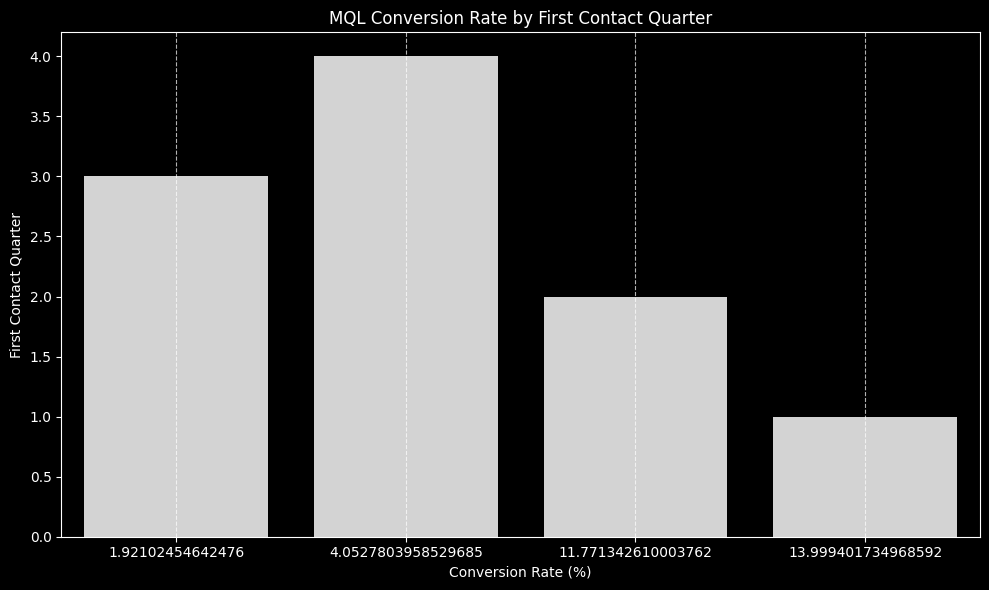

Chi-squared test for first_contact_quarter: p-value = 0.0000
  -> first_contact_quarter is statistically significant in predicting MQL conversion (p < 0.05).


In [66]:
        # Visualize
        plt.figure(figsize=(10, 6))
        sns.barplot(x='conversion_rate_%', y=predictor, data=conversion_rate_df, color=BAR_COLOR)
        plt.title(f'MQL Conversion Rate by {predictor.replace("_", " ").title()}')
        plt.xlabel('Conversion Rate (%)')
        plt.ylabel(predictor.replace("_", " ").title())
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Chi-squared test for statistical significance
        contingency_table = pd.crosstab(df_all_mqls[predictor], df_all_mqls['is_converted'])
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            try:
                chi2, p_val, dof, expected = chi2_contingency(contingency_table)
                print(f"Chi-squared test for {predictor}: p-value = {p_val:.4f}")
                if p_val < 0.05:
                    print(f"  -> {predictor} is statistically significant in predicting MQL conversion (p < 0.05).")
                else:
                    print(f"  -> {predictor} is NOT statistically significant in predicting MQL conversion (p >= 0.05).")
            except ValueError as e:
                print(f"  -> Could not perform Chi-squared test for {predictor}: {e}. Check if categories have zero counts in one of the conversion groups.")
        else:
             print(f"  -> Not enough variation in data to perform Chi-squared test for {predictor} (table shape: {contingency_table.shape}).")


In [67]:
# Step 4: Define MQL Segments by Conversion Potential
print("\n--- Defining MQL Segments by Conversion Potential ---")

# Based on the analysis above, identify 3-5 strongest predictors.
# For demonstration, let's assume 'origin' and 'first_contact_month' are strong.

# Example Segmentation Logic (adjust based on your EDA findings!)
# High Potential: e.g., 'organic_search' + specific months/landing pages
# Medium Potential: e.g., 'social' + other months
# Low Potential: e.g., 'direct_traffic' or 'unknown' origin

# Let's use 'origin' and 'first_contact_day_of_week' for this example.
df_all_mqls['mql_segment'] = 'Other Potential' # Default segment



--- Defining MQL Segments by Conversion Potential ---


In [68]:
# Step 4: Define MQL Segments by Conversion Potential
print("\n--- Defining MQL Segments by Conversion Potential ---")

# Based on the analysis above, identify 3-5 strongest predictors.
# For demonstration, let's assume 'origin' and 'first_contact_month' are strong.

# Example Segmentation Logic (adjust based on your EDA findings!)
# High Potential: e.g., 'organic_search' + specific months/landing pages
# Medium Potential: e.g., 'social' + other months
# Low Potential: e.g., 'direct_traffic' or 'unknown' origin

# Let's use 'origin' and 'first_contact_day_of_week' for this example.
# You will replace these with the actual significant predictors from your output.
df_all_mqls['mql_segment'] = 'Other Potential' # Default segment

# Example 1: High Potential (e.g., 'organic_search' leads)
df_all_mqls.loc[
    (df_all_mqls['origin'] == 'organic_search'),
    'mql_segment'
] = 'High Potential - Organic Search'

# Example 2: Medium Potential (e.g., 'social' leads)
df_all_mqls.loc[
    (df_all_mqls['origin'] == 'social'),
    'mql_segment'
] = 'Medium Potential - Social'

# Example 3: Low Potential (e.g., 'direct_traffic' leads)
df_all_mqls.loc[
    (df_all_mqls['origin'] == 'direct_traffic'),
    'mql_segment'
] = 'Low Potential - Direct Traffic'

df_all_mqls.loc[
    (df_all_mqls['origin'] == 'organic_search') &
    (df_all_mqls['first_contact_day_of_week'].isin(['Monday', 'Tuesday'])),
    'mql_segment'
] = 'Very High Potential - Organic (Mon/Tue)'


print("\nDistribution of MQL Segments:")
print(df_all_mqls['mql_segment'].value_counts())


--- Defining MQL Segments by Conversion Potential ---

Distribution of MQL Segments:
mql_segment
Other Potential                            3855
High Potential - Organic Search            1473
Medium Potential - Social                  1350
Very High Potential - Organic (Mon/Tue)     823
Low Potential - Direct Traffic              499
Name: count, dtype: int64


In [69]:
# Step 5: Analyze and Visualize Segments' Conversion Rates
print("\n--- Analyzing MQL Segments' Conversion Rates ---")

segment_conversion = df_all_mqls.groupby('mql_segment').agg(
    total_mqls=('mql_id', 'count'),
    converted_mqls=('is_converted', lambda x: x.sum())
).reset_index()
segment_conversion['conversion_rate_%'] = (segment_conversion['converted_mqls'] / segment_conversion['total_mqls']) * 100
segment_conversion = segment_conversion.sort_values(by='conversion_rate_%', ascending=False)

print("\nMQL Conversion Rate by Segment:")
print(segment_conversion)


--- Analyzing MQL Segments' Conversion Rates ---

MQL Conversion Rate by Segment:
                               mql_segment  total_mqls  converted_mqls  \
4  Very High Potential - Organic (Mon/Tue)         823             106   
3                          Other Potential        3855             440   
1           Low Potential - Direct Traffic         499              56   
0          High Potential - Organic Search        1473             165   
2                Medium Potential - Social        1350              75   

   conversion_rate_%  
4              12.88  
3              11.41  
1              11.22  
0              11.20  
2               5.56  


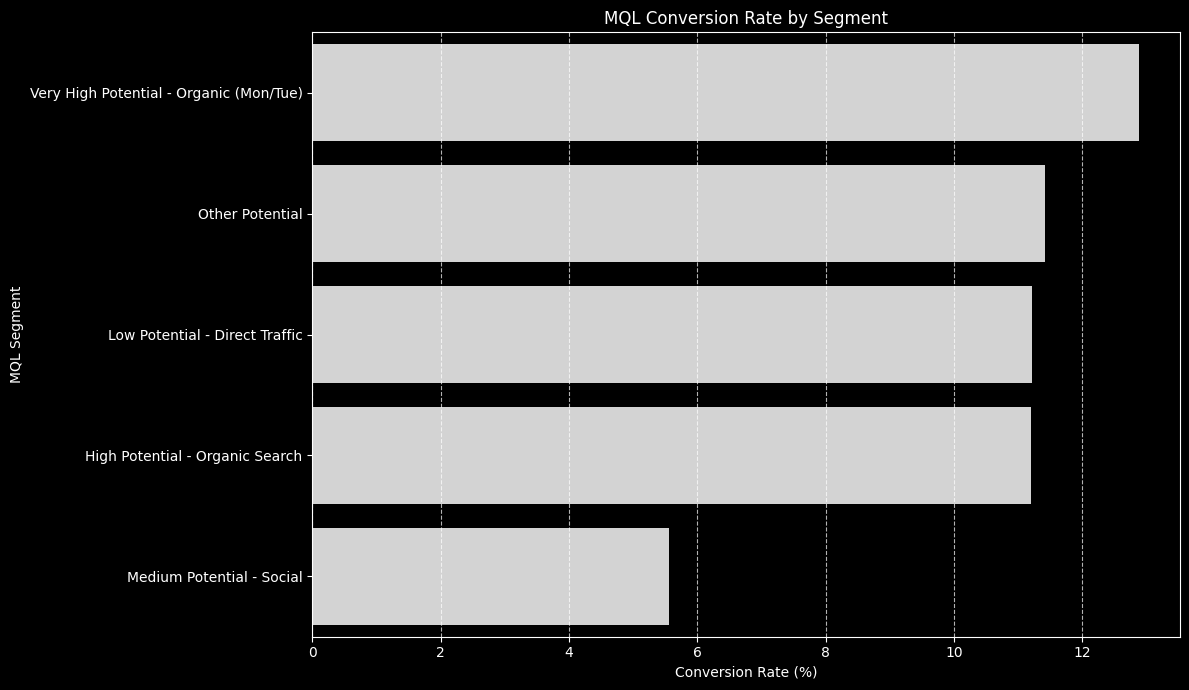

In [70]:
# Visualize segment conversion rates
plt.figure(figsize=(12, 7))
sns.barplot(x='conversion_rate_%', y='mql_segment', data=segment_conversion, color=BAR_COLOR)
plt.title('MQL Conversion Rate by Segment')
plt.xlabel('Conversion Rate (%)')
plt.ylabel('MQL Segment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [71]:
print("\n--- Summary for NEW GOAL 2: MQL Segmentation ---")
print("MQLs have been segmented based on their attributes and analyzed for conversion potential.")
print("The segments highlight different conversion rates, enabling targeted marketing and sales efforts.")
print("The specific rules for segmentation should be refined based on the statistical significance and practical interpretability of the MQL attributes.")

# Save the DataFrame with segments for potential use in SQL/Tableau
df_all_mqls.to_csv('df_all_mqls_with_segments.csv', index=False)
print("\nDataFrame 'df_all_mqls_with_segments.csv' saved for subsequent analysis and visualization.")




--- Summary for NEW GOAL 2: MQL Segmentation ---
MQLs have been segmented based on their attributes and analyzed for conversion potential.
The segments highlight different conversion rates, enabling targeted marketing and sales efforts.
The specific rules for segmentation should be refined based on the statistical significance and practical interpretability of the MQL attributes.

DataFrame 'df_all_mqls_with_segments.csv' saved for subsequent analysis and visualization.
